In [1]:
from __future__ import print_function
import numpy as np
from scipy import ndimage
import pandas as pd
from six.moves import cPickle as pickle
import os
import sys
import tensorflow as tf
%matplotlib inline

In [2]:
#load dataset

pickle_file='IMAGE_data.pickle'
with open(pickle_file,'rb') as f:
    data=pickle.load(f)
    train_dataset=data['train_dataset']
    train_labels=data['train_labels']
    valid_dataset=data['valid_dataset']
    valid_labels=data['valid_labels']
    test_dataset=data['test_dataset']
    test_labels=data['test_labels']
    f.close()
    del data

In [3]:
#reformat the dataset

image_size=28
cloth_labels=2
cloth_channels=3 #rgb

def reformat(dataset,labels):
    dataset=dataset.reshape((-1,image_size,image_size,cloth_channels)).astype(float)
    labels=(np.arange(cloth_labels)==labels[:,None]).astype(float)
    return dataset,labels

In [4]:
#call reformat() and print the reformated dataset

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Train:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Test:', test_dataset.shape, test_labels.shape)


Train: (45, 28, 28, 3) (45, 2)
Validation: (10, 28, 28, 3) (10, 2)
Test: (7, 28, 28, 3) (7, 2)


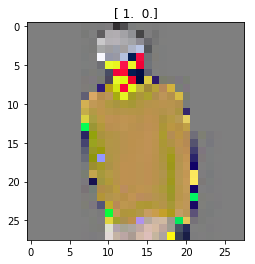

In [5]:
import matplotlib.pyplot as plt
img=train_dataset[2, :, :, :]
plt.title(train_labels[2,:])
plt.imshow(img)

In [6]:
#Accuracy

def accuracy(predictions,labels):
    return (100.0*np.sum(np.argmax(predictions,1)==np.argmax(labels,1))/predictions.shape[0])

In [7]:
#initialize
batch_size=16
patch_size=5
depth=4
more_depth=5
num_hidden=6
image_size=28


graph=tf.Graph()
with graph.as_default():
    tf_train_dataset=tf.placeholder(tf.float32,shape=(batch_size,image_size,image_size,cloth_channels))
    tf_train_labels=tf.placeholder(tf.float32,shape=(batch_size,cloth_labels))
    tf_valid_dataset=tf.constant(valid_dataset)
    tf_test_dataset=tf.constant(test_dataset)
    
    # Weight and Bias Parameters
    K=2
    ###### Layer 1
    w1=tf.Variable(tf.truncated_normal(shape=[patch_size,patch_size,cloth_channels,K],stddev=0.1)) ##### W[5,5,1,4] ->[,28,28,4]
    b1=tf.Variable(tf.zeros([K]))
    
    ###### Layer 2
    w2=tf.Variable(tf.truncated_normal(shape=[patch_size,patch_size,K,depth],stddev=0.1))  ##### W[5,5,4,16] ->[,14,14,16]
    b2=tf.Variable(tf.constant(1.0,shape=[depth]))
    
    ###### Layer 3
    w3=tf.Variable(tf.truncated_normal(shape=[patch_size,patch_size,depth,more_depth],stddev=0.1))  ###### W[5,5,16,16] ->[,7,7,16]
    b3=tf.Variable(tf.constant(1.0,shape=[more_depth]))
    
    ###### connected Layer
    w4=tf.Variable(tf.truncated_normal(shape=[image_size//4 * image_size//4 * more_depth,num_hidden],stddev=0.1)) ##### W[7*7*16,64] ->[,64]
    b4=tf.Variable(tf.constant(1.0,shape=[num_hidden]))
    
    ###### final layer
    w5=tf.Variable(tf.truncated_normal(shape=[num_hidden,cloth_labels],stddev=0.1)) ####### W[64,10]
    b5=tf.Variable(tf.constant(1.0, shape=[cloth_labels]))
    
    
    # Computing CNN model
    def model(data):
        conv1=tf.nn.relu(tf.nn.conv2d(data,w1, strides=[1,1,1,1],padding='SAME') +b1)
        
        conv2=tf.nn.relu(tf.nn.conv2d(conv1,w2, strides=[1,2,2,1], padding='SAME') +b2)
        
        conv3=tf.nn.relu(tf.nn.conv2d(conv2,w3, strides=[1,2,2,1], padding='SAME') +b3)
        
        conv3_shape=conv3.get_shape().as_list()
        conv3_reshape=tf.reshape(conv3, [conv3_shape[0],conv3_shape[1]*conv3_shape[2]*conv3_shape[3]])
        
        #connected Layer
        connec=tf.nn.relu(tf.matmul(conv3_reshape,w4) +b4)
        
        return (tf.matmul(connec,w5) +b5)
    
    # Train Computation
    logits=model(tf.cast(tf_train_dataset,dtype=tf.float32))
    loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    # Optimizer
    optimizer=tf.train.GradientDescentOptimizer(0.005).minimize(loss)
    
    #Predictions
    train_prediction=tf.nn.softmax(logits)
    test_prediction=tf.nn.softmax(model(tf.cast(tf_test_dataset,dtype=tf.float32)))
    valid_prediction=tf.nn.softmax(model(tf.cast(tf_valid_dataset,dtype=tf.float32)))

Initialised......
loss at 0:0.602419
Mini Batch Accuracy:75.00%
Validation Accuracy:50.00%
loss at 10:0.527322
Mini Batch Accuracy:81.25%
Validation Accuracy:50.00%
loss at 20:0.566042
Mini Batch Accuracy:75.00%
Validation Accuracy:50.00%
loss at 30:0.504575
Mini Batch Accuracy:81.25%
Validation Accuracy:50.00%
loss at 40:0.625795
Mini Batch Accuracy:68.75%
Validation Accuracy:50.00%
loss at 50:0.418173
Mini Batch Accuracy:87.50%
Validation Accuracy:50.00%
loss at 60:0.563996
Mini Batch Accuracy:75.00%
Validation Accuracy:50.00%
loss at 70:0.489381
Mini Batch Accuracy:81.25%
Validation Accuracy:50.00%
loss at 80:0.706161
Mini Batch Accuracy:62.50%
Validation Accuracy:50.00%
loss at 90:0.631862
Mini Batch Accuracy:68.75%
Validation Accuracy:50.00%
loss at 100:0.628989
Mini Batch Accuracy:68.75%
Validation Accuracy:50.00%
------------------------------
Test Accuracy:71.43%


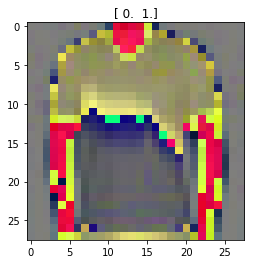

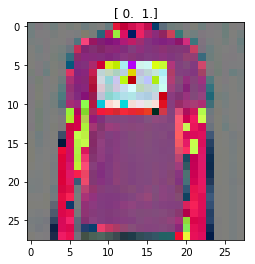

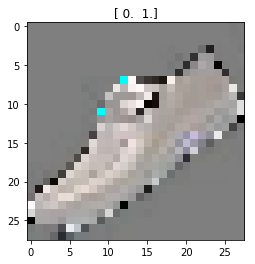

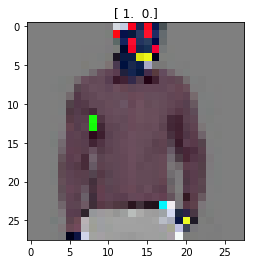

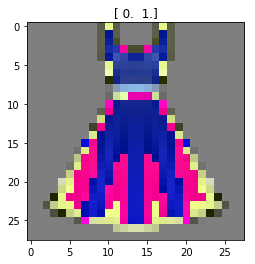

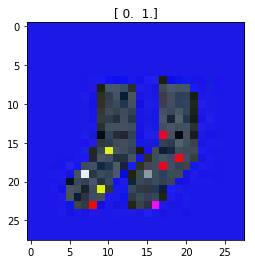

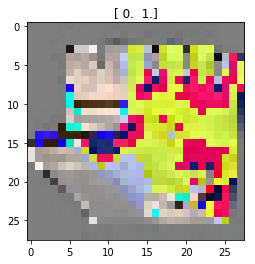

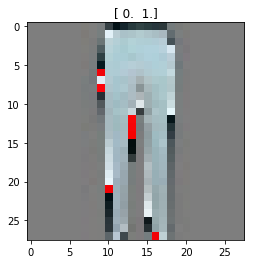

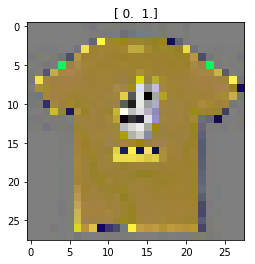

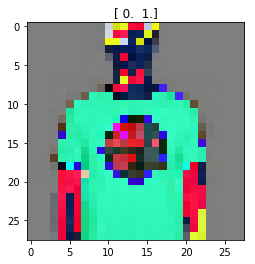

In [8]:
# Iterate the model and train 
num_steps=101

    
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print("Initialised......")
    saver=tf.train.Saver()
    for step in range(num_steps):
        offset=np.random.randint(0,(45-batch_size))
        
        batch_data=train_dataset[offset:(offset+batch_size),:,:,:]
        batch_labels=train_labels[offset:(offset+batch_size),:]
        
        feed_dict={tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        opt,l,pred=sess.run([optimizer,loss,train_prediction],feed_dict=feed_dict)
        if (step%10==0):
            print("loss at %d:%f" %(step,l))
            print("Mini Batch Accuracy:%.2f%%" %accuracy(pred,batch_labels))
            index=np.random.randint(offset,offset+batch_size-1)
            plt.figure(index)
            plt.imshow(train_dataset[index, :, :, :])
            plt.title(train_labels[index])
        
            print("Validation Accuracy:%.2f%%" %accuracy(valid_prediction.eval(),valid_labels))
    print("-"*30)
    
    print("Test Accuracy:%.2f%%" %accuracy(test_prediction.eval(),test_labels))
    saver.save(sess,'image-classify')